# Imports and Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.utils import algorithm_globals
from scipy.optimize import minimize
from qiskit.quantum_info import Pauli
from qiskit_aer.primitives import Estimator
from numpy.typing import NDArray

algorithm_globals.random_seed = 42

In [2]:
num_inputs = 1 # num of features (p)
num_samples_train = 8 # num of instances (n)
num_samples_test = 4
num_params = 4
nb_iter = 1

In [3]:
# Points between -2 and 2 on a single axis
X = 4 * algorithm_globals.random.random(num_samples_train) - 2  
X_test = 4 * algorithm_globals.random.random(num_samples_test) - 2

# Blue if between -1 and 1, red otherwise
Y = np.where((X >= -1) & (X <= 1), 1, -1)  # Y contains 1 and -1
Y_test = np.where((X_test >= -1) & (X_test <= 1), 1, -1)

# Ensure the arrays are of type float64
X = X.astype(np.float64)
Y = Y.astype(np.float64)
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.float64)

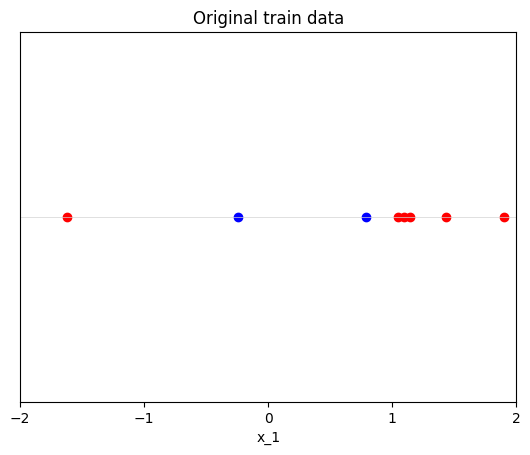

In [4]:
# On plot la distribution
for x_i, y_i in zip(X, Y):
    if y_i == 1:
        plt.plot(x_i, 0, "bo") 
    else:
        plt.plot(x_i, 0, "ro")

plt.axhline(0, color="lightgray", linewidth=0.5)
plt.title("Original train data")
plt.xlabel("x_1")
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([])
plt.xlim(-2, 2)
plt.show()

# Circuit

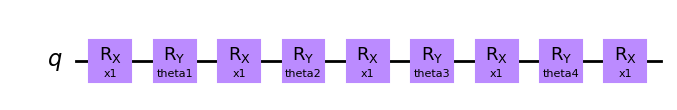

In [5]:
# Le circuit contient 1 input et 4 paramètres à entrainer
params5 = [Parameter("x1"), Parameter("theta1"), Parameter("theta2"), Parameter("theta3"), Parameter("theta4")]
# Le circuit utilise un seul qubit
qcc = QuantumCircuit(1) 
# On suit l'architecture du papier
qcc.rx(params5[0], 0)
qcc.ry(params5[1], 0)
qcc.rx(params5[0], 0)
qcc.ry(params5[2], 0)
qcc.rx(params5[0], 0)
qcc.ry(params5[3], 0)
qcc.rx(params5[0], 0)
qcc.ry(params5[4], 0)
qcc.rx(params5[0], 0)

qcc.draw("mpl", style="clifford")

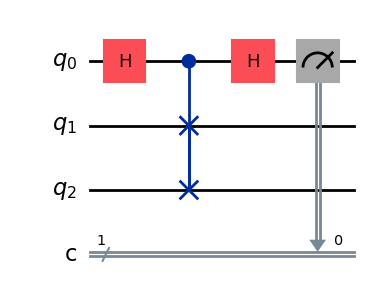

In [6]:

#Only for illustration purposes
swapCircuit = QuantumCircuit(3, 1)

swapCircuit.h(0)
swapCircuit.cswap(0, 1, 2)
swapCircuit.h(0)

swapCircuit.measure(0, 0)

swapCircuit.draw("mpl")

# Model

In [7]:
class QuantumModel() :
    def __init__(self, circuit: QuantumCircuit, params: NDArray[np.float64], X: NDArray[np.float64], Y: NDArray[np.float64]):
        self.circuit: QuantumCircuit = circuit #The circuit outputs an embedding
        self.params: NDArray[np.float64] = params
        self.X: NDArray[np.float64] = X
        self.Y: NDArray[np.float64] = Y
        self.Xpositive: NDArray[np.float64] = self.X[self.Y == 1]
        self.Xnegative: NDArray[np.float64] = self.X[self.Y == -1]

        self.estimator = Estimator()
        self.pauli_z = Pauli('ZII')

    def updateParams(self, new_params: NDArray[np.float64]) :
        self.params: NDArray[np.float64] = new_params

    def fullSwapTestCircuit(self, x1: np.float64, x2: np.float64) -> QuantumCircuit :
        """
        Returns a circuit that computes the swap test between two states, using self.params as parameters
        """

        fullParams1 = {params5[0] : x1, params5[1] : self.params[0], params5[2] : self.params[1], params5[3] : self.params[2], params5[4] : self.params[3]}
        circuit1 = self.circuit.copy()
        circuit1.assign_parameters(fullParams1)

        fullParams2 = {params5[0] : x2, params5[1] : self.params[0], params5[2] : self.params[1], params5[3] : self.params[2], params5[4] : self.params[3]}
        circuit2 = self.circuit.copy()
        circuit2.assign_parameters(fullParams2)

        qc = QuantumCircuit(3, 1)

        qc.h(0)
        qc.compose(circuit1, [1], inplace=True)
        qc.compose(circuit2, [2], inplace=True)
        qc.cswap(0, 1, 2)
        qc.h(0)

        qc.measure(0, 0)

        return qc

    def fidelity(self, x1: np.float64, x2: np.float64) -> np.float64:
        # Create a copy of the circuit to avoid modifying the original circuit
        circuit1 = self.circuit.copy()
        circuit2 = self.circuit.copy()

        # Assign parameters to the circuits
        fullParams1 = {
            params5[0]: x1,
            params5[1]: self.params[0],
            params5[2]: self.params[1],
            params5[3]: self.params[2],
            params5[4]: self.params[3]
        }
        circuit1 = circuit1.assign_parameters(fullParams1)

        fullParams2 = {
            params5[0]: x2,
            params5[1]: self.params[0],
            params5[2]: self.params[1],
            params5[3]: self.params[2],
            params5[4]: self.params[3]
        }
        circuit2 = circuit2.assign_parameters(fullParams2)

        # Create the swap test circuit
        qc = QuantumCircuit(3, 1)
        qc.h(0)
        qc.compose(circuit1, [1], inplace=True)
        qc.compose(circuit2, [2], inplace=True)
        qc.cswap(0, 1, 2)
        qc.h(0)
        qc.measure(0, 0)

        # Run the estimator
        job = self.estimator.run([qc], [self.pauli_z])
        result = job.result().values[0]

        return np.float64(result)

    def trace(self, class1: NDArray[np.float64], class2: NDArray[np.float64]) -> np.float64 :
        """
        Compute the trace of the density matrix of class1 multiplied by the density matrix of class2

        class1, class2 are arrays of data corresponding to each class
        """
        result = np.float64(0)


        for x1 in class1 :
            for x2 in class2 :
                result += self.fidelity(x1, x2)
        
        return result

    def Dhs(self) -> np.float64 :
        return self.trace(self.Xpositive, self.Xpositive) + self.trace(self.Xnegative, self.Xnegative) - 2*self.trace(self.Xpositive, self.Xnegative)

    def loss(self) -> np.float64 :
        return 1-0.5*self.Dhs()
    
    def xrhox(self, x: np.float64, class1: NDArray[np.float64]) -> np.float64 :
        result = np.float64(0)

        for x1 in class1 :
            result += self.fidelity(x, x1)
        
        return result
    
    def fidelityMeasurement(self, x: np.float64) -> np.float64 :
        return self.xrhox(x, self.Xpositive) - self.xrhox(x, self.Xnegative)
    
    def predictArray(self, X: NDArray[np.float64]) -> NDArray[np.float64] :
        return np.array([self.fidelityMeasurement(x) for x in X])

In [8]:
initParams = np.zeros(num_params, dtype=np.float64)

model = QuantumModel(qcc, initParams, X, Y)

C:\Users\sandr\AppData\Local\Temp\ipykernel_13848\1185181023.py:3: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  model = QuantumModel(qcc, initParams, X, Y)
C:\Users\sandr\AppData\Local\Temp\ipykernel_13848\1185181023.py:3: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  model = QuantumModel(qcc, initParams, X, Y)


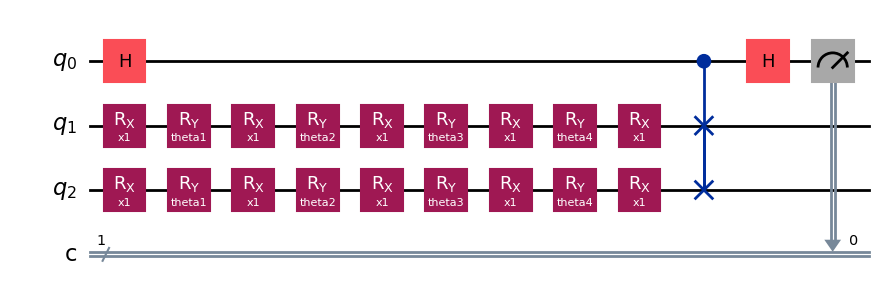

In [9]:
cc = model.fullSwapTestCircuit(np.float64(11), np.float64(22))

cc.draw("mpl")

# Optimisation

In [10]:
countCalls = 0

In [11]:
def objectiveFunction(params_: NDArray[np.float64]) -> np.float64 :

    model.updateParams(params_)
    loss = model.loss()

    global countCalls
    countCalls += 1

    return loss


In [12]:

def train() :
    result = minimize(objectiveFunction, initParams, method="COBYLA", options={'maxiter': nb_iter})

    return result

result = train()
print(result)


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -2.4677734375
       x: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
    nfev: 1
   maxcv: 0.0


In [13]:
print(countCalls)

1


# Inference

In [14]:
x = np.float64(0.22)

print(model.fidelityMeasurement(x))

-1.83984375
